In [1]:
!gdown "1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96" -O "tumor_dataset.rar"

Downloading...
From: https://drive.google.com/uc?id=1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96
To: /content/tumor_dataset.rar
100% 317M/317M [00:02<00:00, 156MB/s]


In [2]:
!pip install unrar -q

In [3]:
!rm -rf "/content/tumor_dataset"
!unrar x "tumor_dataset.rar" &> /dev/null

In [4]:
!ls -l "/content/tumor_dataset/Glioma/" | wc -l
!ls -l "/content/tumor_dataset/Meningioma" | wc -l
!ls -l "/content/tumor_dataset/Pituitary/" | wc -l

1427
709
931


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc
import tensorflow as tf

In [6]:
# Restrict TensorFlow to only allocate GPU memory as needed
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [7]:
# Define hyperparameters
input_shape = (224, 224,3)
num_classes = 3
learning_rate = 0.0001
batch_size = 32
num_epochs = 5

In [8]:
# dataset path and image size
# dataset_path = "/content/drive/MyDrive/brain_tumor_dataset/"
dataset_path = "/content/tumor_dataset"


# Load and preprocess the dataset
classes = ["Glioma", "Meningioma", "Pituitary"]
images = []
labels = []

for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_bmp(image, channels=3)
        image = tf.image.resize(image, input_shape[:2])  # Resize to input_shape
        image = tf.cast(image, tf.float32) / 255.0  # Normalize
        images.append(image)
        labels.append(i)

images = np.array(images)
labels = np.array(labels)

# Create train-test split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Convert labels to categorical format
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

print('[train_images_path]', len(train_images), train_images[0], train_images[-1])
print('[train_labels]', len(train_labels), train_labels[:10], train_labels[-10:])
print('[test_images_path]', len(test_images), test_images[0], test_images[-1])
print('[test_labels]', len(test_labels), test_labels[:10], test_labels[-10:])
print('[val_images]', len(val_images), val_images[0], val_images[-1])
print('[val_labels]', len(val_labels), val_labels[:10], val_labels[-10:])

[train_images_path] 1960 [[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00252101 0.00252101 0.00252101]
  [0.00252101 0.00252101 0.00252101]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00476191 0.00476191 0.00476191]
  [0.00476191 0.00476191 0.00476191]
  [0.00392157 0.00392157 0.00392157]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00868339 0.00868339 0.00868339]
  [0.00784314 0.00784314 0.00784314]
  [0.00476182 0.00476182 0.00476182]]

 [[0.         0.         0.        ]
  [0.       

In [9]:
def AlexNet(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model



In [10]:
# Create an instance of the AlexNet model
model = AlexNet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [11]:
# Train the model
model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)


Epoch 1/5
62/62 [==============================] - 20s 69ms/step - loss: 0.9149 - accuracy: 0.6347 - val_loss: 0.9963 - val_accuracy: 0.6986
Epoch 2/5
62/62 [==============================] - 3s 48ms/step - loss: 0.5300 - accuracy: 0.7628 - val_loss: 0.9490 - val_accuracy: 0.6802
Epoch 3/5
62/62 [==============================] - 3s 54ms/step - loss: 0.4269 - accuracy: 0.8122 - val_loss: 0.9086 - val_accuracy: 0.5703
Epoch 4/5
62/62 [==============================] - 3s 56ms/step - loss: 0.3578 - accuracy: 0.8403 - val_loss: 0.9327 - val_accuracy: 0.5275
Epoch 5/5
62/62 [==============================] - 3s 51ms/step - loss: 0.2836 - accuracy: 0.8791 - val_loss: 0.4862 - val_accuracy: 0.7923


In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 [==============================] - 1s 37ms/step - loss: 0.5241 - accuracy: 0.8042
Test Loss: 0.5241
Test Accuracy: 0.8042


In [13]:
test_predictions = model.predict(test_images)



20/20 [==============================] - 1s 23ms/step


In [14]:
predicted_labels = np.argmax(test_predictions, axis=1)

In [15]:
test_probs = model.predict(test_images)

20/20 [==============================] - 0s 19ms/step


In [20]:
# Calculate precision, recall, and F1-score for each class
Accuracy= accuracy_score(test_labels.argmax(axis=1),predicted_labels)
precision_per_class = precision_score(test_labels.argmax(axis=1), predicted_labels, average=None)
recall_per_class = recall_score(test_labels.argmax(axis=1), predicted_labels, average=None)
f1_per_class = f1_score(test_labels.argmax(axis=1), predicted_labels, average=None)

for class_idx, class_name in enumerate(classes):
    print(f"Class: {class_name}")
    print(f"Accuracy: {Accuracy}")
    print(f"Precision: {precision_per_class[class_idx]}")
    print(f"Recall: {recall_per_class[class_idx]}")
    print(f"F1-score: {f1_per_class[class_idx]}")
    print()

Class: Glioma
Accuracy: 0.8042414355628059
Precision: 0.7755102040816326
Recall: 0.9333333333333333
F1-score: 0.8471337579617835

Class: Meningioma
Accuracy: 0.8042414355628059
Precision: 0.9787234042553191
Recall: 0.323943661971831
F1-score: 0.48677248677248686

Class: Pituitary
Accuracy: 0.8042414355628059
Precision: 0.8116591928251121
Recall: 0.9731182795698925
F1-score: 0.8850855745721272



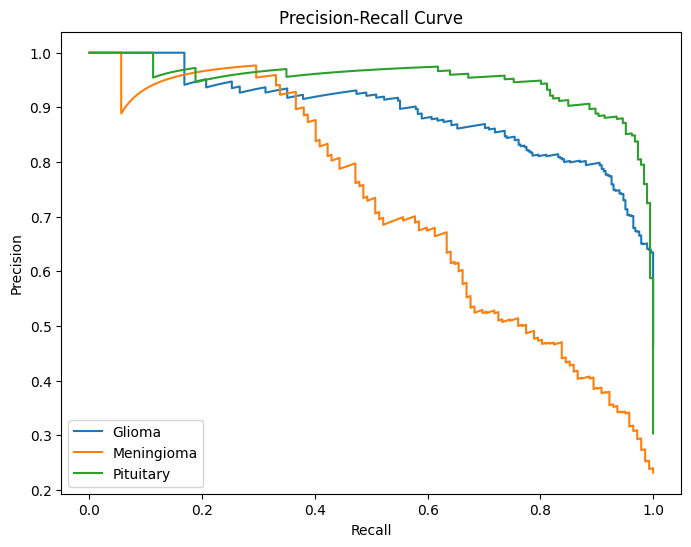

In [21]:
from sklearn.metrics import precision_recall_curve


# Compute precision and recall for each class
precisions = dict()
recalls = dict()
for i in range(num_classes):
    class_probs = test_probs[:, i]
    precision, recall, _ = precision_recall_curve(test_labels[:, i], class_probs)
    precisions[i] = precision
    recalls[i] = recall

# Plot the precision-recall curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recalls[i], precisions[i], label=classes[i])
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


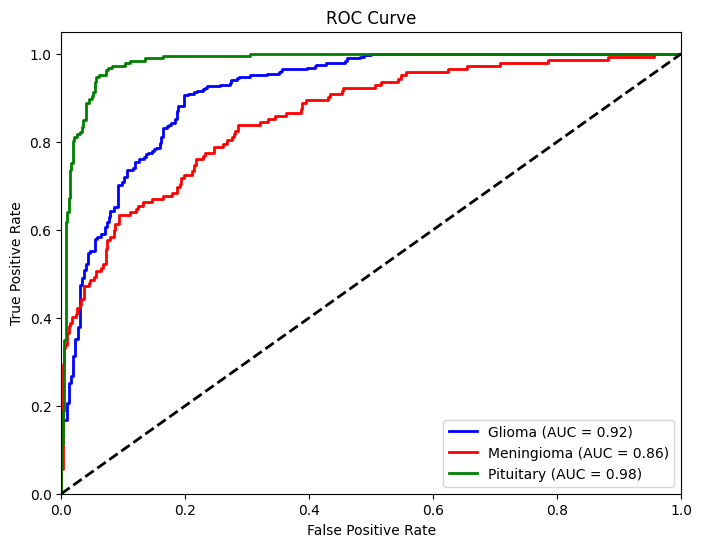

In [22]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Compute confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[266   1  18]
 [ 72  46  24]
 [  5   0 181]]
